In [ ]:
#text classification from keras
#1. do the essential imports
#2. download the dataset
#3. view the dataset statistics
#4. preprocess the dataset
#5. build the model
#6. Compile the model with loss function and optimizer
#7. Create the validation set
#8. training the model
#9. do model evaluation on test set
#10. Plot the accuaracy and loss after training is done

In [1]:
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
import numpy as np

Using TensorFlow backend.


Couldn't import dot_parser, loading of dot files will not be possible.


In [4]:

imdb = keras.datasets.imdb
#to keep the top 10k words in the review sequence
(train_reviews, train_labels), (test_reviews, test_labels) = imdb.load_data(num_words=10000)

17473536/17464789 [==============================] - 81s 5us/step


In [7]:
print("Training entries: {}".format(len(train_reviews)))
print("Labels: {}".format(len(train_labels)))
# print("Training entries: {}, labels: {}".format(len(train_data), len(train_labels)))
print(train_reviews[0])

Training entries: 25000
Labels: 25000
[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]


In [20]:
#3. write some utility functions
#dictionary maps words to index
word_index = imdb.get_word_index()
word_index = {k:v+3 for (k, v) in word_index.items()}
#add more 4 words to the dictionary
word_index["<PAD>"]    = 0
word_index["<START>"]  = 1
word_index["<UNK>"]    = 2
word_index["<UNUSED>"] = 3
reversed_word_index     = dict([(value, key) for (key, value) in word_index.items()])


In [21]:
#decode the review
def decode_review(text):
    return ' '.join([reversed_word_index.get(i, '?') for i in text])

In [22]:
print(decode_review(train_reviews[0]))


<START> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <UNK> and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <UNK> to the two little boy's that played the <UNK> of norman and paul they were just brilliant children are often left out of the <UNK> list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for wha

In [26]:
train_reviews = keras.preprocessing.sequence.pad_sequences(train_reviews,
                                                        value=word_index["<PAD>"],
                                                        padding='post',
                                                        maxlen=256)

test_reviews = keras.preprocessing.sequence.pad_sequences(test_reviews,
                                                       value=word_index["<PAD>"],
                                                       padding='post',
                                                       maxlen=256)


In [32]:
print(len(train_reviews[0]))
print(len(test_reviews[0]))
# print(train_reviews[0])

256
256


In [33]:
#build the model part
#a. how many layers to use in the model
#b. how many neurons in each of the model
#input: sequence of word indices
#output: review 0/1 sentiment
# input shape is the vocabulary count used for the movie reviews (10,000 words)
vocab_size = 10000
model = keras.Sequential()
#Add the embedding layer. This takes integer encoded vocab and looks for embedding for each of the word
#output is :(batch, sequence, embedding).
model.add(keras.layers.Embedding(vocab_size, 16))
#returns a fixed-length output vector for each example by averaging over the sequence dimension
model.add(keras.layers.GlobalAveragePooling1D())
#dense layers of 16 neurons
model.add(keras.layers.Dense(16, activation=tf.nn.relu))
#single output neuron
model.add(keras.layers.Dense(1, activation=tf.nn.sigmoid))

model.summary()



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
global_average_pooling1d_1 ( (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 160,289
Trainable params: 160,289
Non-trainable params: 0
_________________________________________________________________


In [34]:
#model training
#it needs the loss function and optimizer to do the training
#LOSS: BinaryCrossEntropyLossFunction: better than square to deal with probabilities which measyres the distance
#between probability distributions
model.compile(optimizer=tf.train.AdamOptimizer(),
              loss='binary_crossentropy',
              metrics=['accuracy'])


In [35]:
#create the validation dataset
x_val = train_reviews[:10000]
partial_x_train = train_reviews[10000:]

y_val = train_labels[:10000]
partial_y_train = train_labels[10000:]


In [36]:
#train on [partial x and y] for 5 lookups of data and batch size 512 with monitoring loss and accuracy on validation set
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=40,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)


Train on 15000 samples, validate on 10000 samples
Epoch 1/40
15000/15000 [==============================] - 1s 93us/step - loss: 0.6914 - acc: 0.6173 - val_loss: 0.6891 - val_acc: 0.5933

In [38]:
#evaluate the model
results = model.evaluate(test_reviews, test_labels)
print(results)

25000/25000 [==============================] - 1s 31us/step
[0.34125996191024782, 0.86899999999999999]


In [39]:
#create a graph over accuracy and loss over time
# model.fit() returns a History object that contains a dictionary with everything that happened during training:
history_dict = history.history
history_dict.keys()


['acc', 'loss', 'val_acc', 'val_loss']

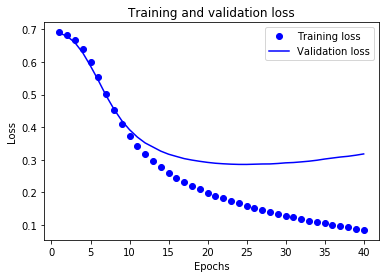

In [40]:
#training and validation loss
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


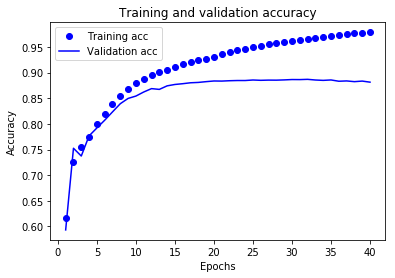

In [41]:
#training and validation accuracy
plt.clf()   # clear figure
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()
